In [1]:
PYTHON_PATHS = [".."]
import sys
for path in PYTHON_PATHS:
    if path not in sys.path:
        sys.path.append(path)

import numpy as np
import matplotlib.pyplot as plt
from optimal_planner.optimal_trajectory import OptimalTrajectory
from optimal_planner.non_holonomic_optimal_trajectory import NonHolonomicOptimalTrajectory

# plot trajectory

In [6]:
goal_point = np.array([1, 1, 1.57])
point_count = 100
start_point = np.array([0, 0, 0])

In [7]:
simple_trajectory = np.zeros((point_count + 2, 3))
simple_trajectory[:, 0] = np.linspace(start_point[0], goal_point[0], point_count + 2)
simple_trajectory[:, 1] = np.linspace(start_point[1], goal_point[1], point_count + 2)
simple_trajectory[:, 2] = np.linspace(start_point[2], goal_point[2], point_count + 2)
simple_trajectory = OptimalTrajectory(simple_trajectory, 1)

In [8]:
def plot_trajectory(trajectory):
    plt.plot(trajectory.x, trajectory.y)
    plt.quiver(trajectory.x, trajectory.y, np.cos(trajectory.angle), np.sin(trajectory.angle), 
               scale=15, headlength=5, headwidth=2)
    plt.gca().set_aspect('equal')

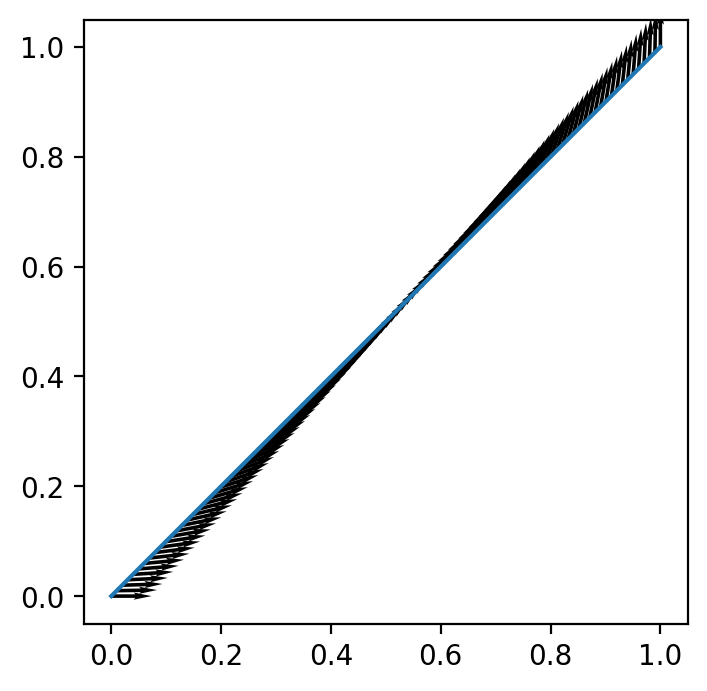

In [9]:
plt.figure(dpi=200)
plot_trajectory(simple_trajectory)

# Optimize simple trajectory

## Scipy optimization

In [10]:
from scipy.optimize import minimize

In [11]:
def loss_function(params, start_point, goal_point, angle_koef=1.):
    return OptimalTrajectory.from_parameters(params, start_point, goal_point, angle_koef).loss()

def jacobian_function(params, start_point, goal_point, angle_koef=1.):
    return OptimalTrajectory.from_parameters(params, start_point, goal_point, angle_koef).jacobian()

def hessian_function(params, start_point, goal_point, angle_koef=1.):
    return OptimalTrajectory.from_parameters(params, start_point, goal_point, angle_koef).hessian()

zero_trajectory = OptimalTrajectory.from_parameters(np.zeros(point_count * 3), start_point, goal_point, angle_koef=1)
result = minimize(loss_function, zero_trajectory.parameters(), args=(start_point, goal_point), 
                  jac=jacobian_function, hess=hessian_function, method='Newton-CG')
loss_function(result.x, start_point, goal_point)

0.04420693069306934

In [12]:
loss_function(simple_trajectory.parameters(), start_point, goal_point)

0.044206930693068656

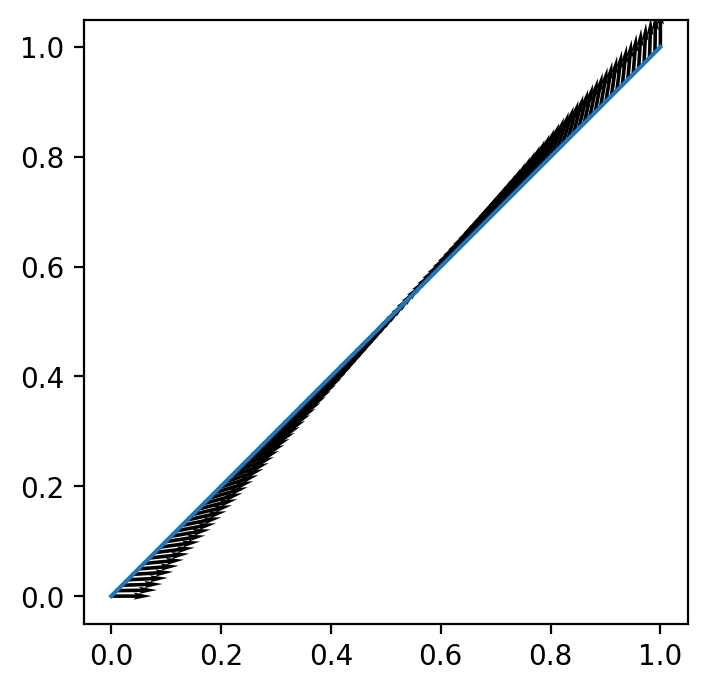

In [13]:
plt.figure(dpi=200)
plot_trajectory(OptimalTrajectory.from_parameters(result.x, start_point, goal_point))

## Scipy with jacobian

# Holonomy constraints

In [14]:
def loss_function(params, start_point, goal_point, angle_koef=1):
    return NonHolonomicOptimalTrajectory.from_parameters(params, start_point, goal_point, angle_koef).loss()

def jacobian_function(params, start_point, goal_point, angle_koef=1):
    return NonHolonomicOptimalTrajectory.from_parameters(params, start_point, goal_point, angle_koef).jacobian()

def hessian_function(params, start_point, goal_point, angle_koef=1):
    return NonHolonomicOptimalTrajectory.from_parameters(params, start_point, goal_point, angle_koef).hessian()

zero_trajectory = NonHolonomicOptimalTrajectory.from_parameters(
    np.zeros(300), start_point, goal_point, angle_koef=1)
# result = minimize(loss_function, simple_trajectory.parameters(), args=(start_point, goal_point))
# loss_function(result.x, start_point, goal_point)
result = minimize(loss_function, simple_trajectory.parameters(), args=(start_point, goal_point), 
                  jac=jacobian_function, hess=hessian_function, method='Newton-CG', options={"eps": 1e3})
loss_function(result.x, start_point, goal_point)

0.04841943537698867

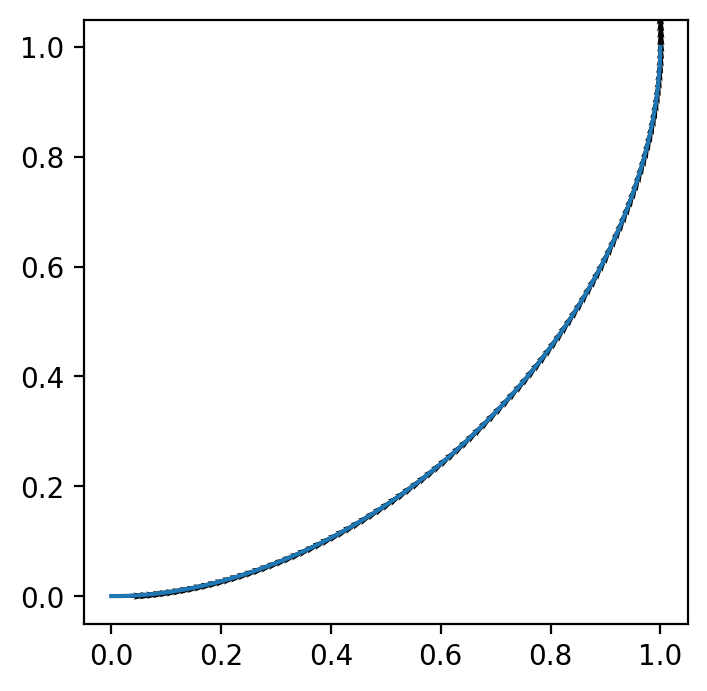

In [15]:
plt.figure(dpi=200)
plot_trajectory(OptimalTrajectory.from_parameters(result.x, start_point, goal_point))

In [16]:
import torch

x = torch.tensor(10, requires_grad=True, dtype=torch.float64)
y = torch.tensor(0, requires_grad=True, dtype=torch.float64)
l = torch.tensor(-100, requires_grad=True, dtype=torch.float64)
lr = 0.1

# min x^2+y^2 s.t x+y = 1
for i in range(100):
    L = x**2 + y**2 + l*(1-x-y)
    L.backward()
    x.data.add_(-lr*x.grad.data)
    y.data.add_(-lr*y.grad.data)
    x.grad.detach_()
    x.grad.zero_()
    y.grad.detach_()
    y.grad.zero_()
    l.grad.detach_()
    l.grad.zero_()
    L = x**2 + y**2 + l*(1-x-y)
    L.backward()
    l.data.add_(lr*l.grad.data)
    x.grad.detach_()
    x.grad.zero_()
    y.grad.detach_()
    y.grad.zero_()
    l.grad.detach_()
    l.grad.zero_()

print(x, y, x+y)

tensor(0.5008, dtype=torch.float64, requires_grad=True) tensor(0.5008, dtype=torch.float64, requires_grad=True) tensor(1.0016, dtype=torch.float64, grad_fn=<AddBackward0>)
